In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:

italian_path = './datasets/italian/italianV1.json'
spanish_path = './datasets/spanish/spanishV1.json'
english_path = './datasets/english/englishV1.json'

def readData(path):
    file = open(path, 'r')
    data = []
    count = 0
    for line in file:
        count += 1
        data.append(json.loads(line))
    print(count, ' documents read from:', path)
    return pd.json_normalize(data)

In [3]:
raw_italian = readData(italian_path)
raw_spanish = readData(spanish_path)
raw_english = readData(english_path)

879887  documents read from: ./datasets/italian/italianV1.json
886351  documents read from: ./datasets/spanish/spanishV1.json
817046  documents read from: ./datasets/english/englishV1.json


In [10]:
raw_spanish

,id,publication_date,source,text
0,1304391319972790274,1.599826e+09,twitter,ORACIÓN DIARIAViernes 11 de Septiembre 2020#or...
1,1308823479077175297,1.600883e+09,twitter,Se pudrió todo. Acá la FIFA debe castigar a la...
2,1255929719893221377,1.588272e+09,twitter,Última Publicación en la Prensaldia - @ca...
3,1367024221319286784,1.614759e+09,twitter,Australia = 0 positivos por coronavirus.¿Vacun...
4,1278689023087849480,1.593698e+09,twitter,coronavirus esto ya es personal
...,...,...,...,...
886346,1236060862122799104,1.583535e+09,twitter,La gente pillando coronavirusY tú sin pillarme...
886347,1380797710693982208,1.618043e+09,twitter,"El martes 27 de abril, no te pierdas el prime..."
886348,1232313141091946496,1.582641e+09,twitter,Italia registra el primer caso de coronavirus ...
886349,1377581882553069569,1.617276e+09,twitter,Colombia registra 8.646 casos nuevos y 167 mue...


Definición de categorías

In [58]:
# Palabras más repetidas - check
# Número total de documentos - check
# Distribución por día de los tweet. - Check
# Promedio de palabras por documento -check
# Distribución del número de palabras por documento- Check
# 


vaccine_en ={
    "name": "vaccine", 
    "values":  [ "vaccine", "Pfizer","astrazeneca", "Janssen" , "moderna"," BioNTech", "Sputnik V", "Johnson & Johnson"," CoronaVac", "Sinovac"]}
vaccination_en = {
    "name": "vaccination", 
    "values": ["vaccination", "dose", "side-effect", "hospital", "injection", "immunity", "anti-bodies"]}
mentalHealth_en = {
    "name": "Mental Health", 
    "values": ["mental-health", "psychiatric","psycologist","depression", "stress", "claustrophobia", "suicide", "sadness", "loneliness"]}
vaccine_it = {
    "name":"vaccino", 
    "values": ["vaccino", "Pfizer", "AstraZeneca", "Janssen", "Moderna"," BioNTech", "Sputnik V", "Johnson & Johnson"," CoronaVac", "Sinovac"]}

vaccination_it ={
    "name":"vaccinazione", 
    "values": [ "vaccinazione", "dose", "effetto collaterale", "ospedale", "iniezione", "immunità", "anticorpi"]}

mentalHealth_it = {
    "name":"Salute mentale", 
    "values": ["salute mentale", "psichiatra", "psicologo", "depressione", "stress", "claustrofobia", "suicidio", "tristezza", "solitudine"]}

vaccine_es = {
    "name": "Vacuna", 
    "values": ["vacuna", "Pfizer", "astrazeneca", "Janssen", "moderna", "BioNTech", "Sputnik V", "Johnson & Johnson", "CoronaVac", "Sinovac"]}
vaccination_es = {
    "name": "Vacunación",
     "values": ["vacunación", "dosis", "efecto secundario", "hospital", "inyección", "inmunidad", "anticuerpos"]}
mentalHealth_es = {
    "name": "Salud mental", 
    "values": ["salud mental", "psiquiátrica", "psicólogo", "depresión", "estrés", "claustrofobia", "suicidio", "tristeza", "soledad"]}

def getCategories(languageName, *args):
    all_categories = []
    vecorizer = CountVectorizer(max_features=20000, stop_words=stopwords.words(languageName))
    for category in args:
        # print(category.items())
        # print(values)
        vectorizer_verdaderas.fit_transform(category["values"])
        all_categories.append({
            "name": category["name"],
             "values": list(vectorizer_verdaderas.vocabulary_.keys())
             })
    
    return all_categories


[vaccine_en, vaccination_en, mentalHealth_en] = getCategories("english", vaccine_en, vaccination_en, mentalHealth_en)

In [33]:
print(vaccine_en)
print(vaccination_en)
print(mentalHealth_en)

{'name': 'vaccine', 'values': ['vaccine', 'pfizer', 'astrazeneca', 'janssen', 'moderna', 'biontech', 'sputnik', 'johnson', 'coronavac', 'sinovac']}
{'name': 'vaccination', 'values': ['vaccination', 'dose', 'side', 'effect', 'hospital', 'injection', 'immunity', 'anti', 'bodies']}
{'name': 'Mental Health', 'values': ['mental', 'health', 'psychiatric', 'psycologist', 'depression', 'stress', 'claustrophobia', 'suicide', 'sadness', 'loneliness']}


Análisis de ocurrencias

Italiano

In [56]:
def plotCategorias(frecuencias, *categorias):
    n = len(categorias)
    # plt.figure(figsize=(10,60)
    plt.rcParams["figure.figsize"] = (20,10)

    for categoria in categorias:
        plt.subplot(1, len(categorias), n)
        n -= 1
        name = categoria['name']
        values = categoria['values']
        freqs = [frecuencias[cat] if cat in frecuencias else 0 for cat in values ]
        plt.bar(values, freqs, width=0.8, color='blue')
        plt.title(f'{name}')
        plt.grid()
        plt.xticks(rotation=270)
    # plt.tight_layout()
    plt.show()

def frecuenciasPorLenguaje(dfLanguage, nombreIdioma, *categorias):

    vectorizer_verdaderas = CountVectorizer(max_features=20000, min_df=5, max_df=0.7, stop_words=stopwords.words(nombreIdioma))

    # Buscar occurencias
    freq_T = vectorizer_verdaderas.fit_transform(dfLanguage['text'].to_list())

    # sumar ocurrencias
    freq_T = np.asarray(freq_T.sum(axis=0)).reshape(20000)

    dict_T = vectorizer_verdaderas.vocabulary_

    #Se le asigna la frecuencia a cada palabra
    freqs = {key: freq_T[dict_T[key]] for key in dict_T.keys()}

    # #Ordenar
    dict_T = {f: v for f, v in sorted(freqs.items(), key=lambda item: item[1], reverse=True)}

    # #Obtener 20 palabras más frecuentes

    dict_T = {k: dict_T[k] for k in list(dict_T)[:20]}

    #Graficar
    plt.rcParams["figure.figsize"] = (20,10)
    plt.bar(dict_T.keys(), dict_T.values(), width=0.8, color='orange')
    plt.title(f'Ocurrencias de palabras en los datos en {nombreIdioma}')
    plt.xticks(rotation=270)
    plt.show()

    plotCategorias(freqs, *categorias)

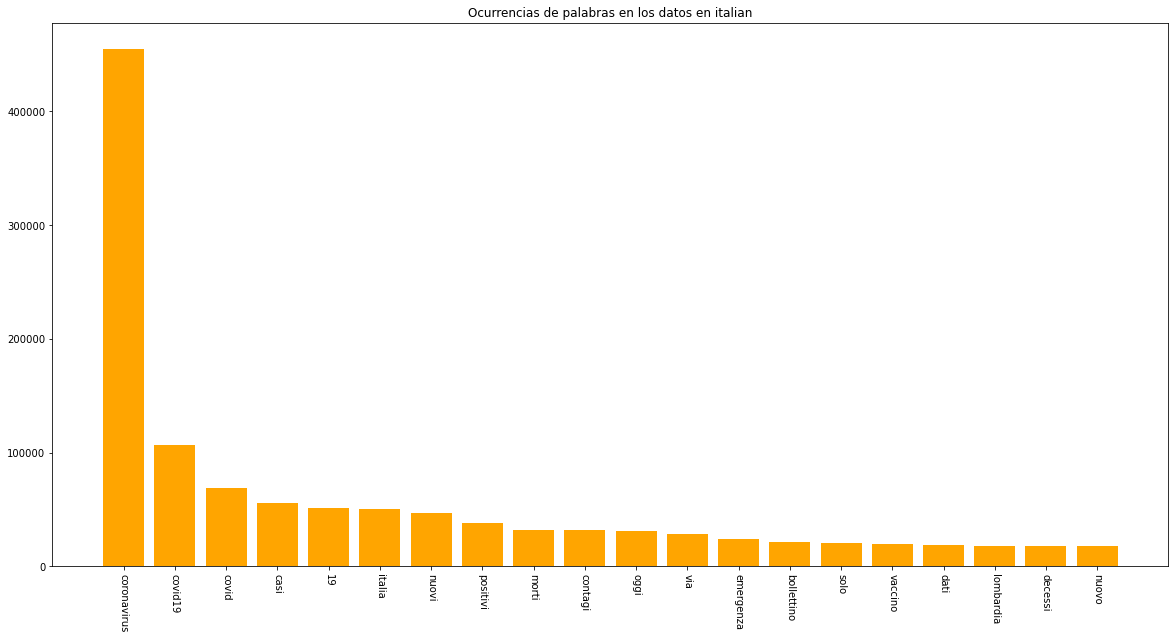

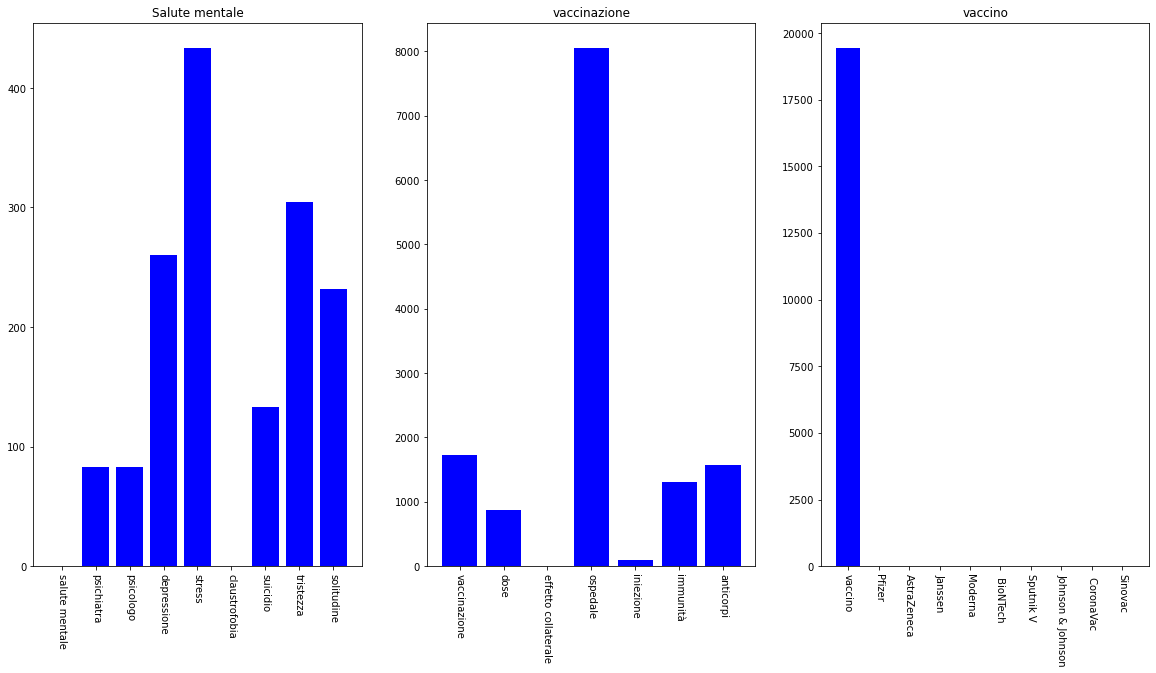

In [60]:
frecuenciasPorLenguaje(raw_italian, 'italian', vaccine_it, vaccination_it, mentalHealth_it)

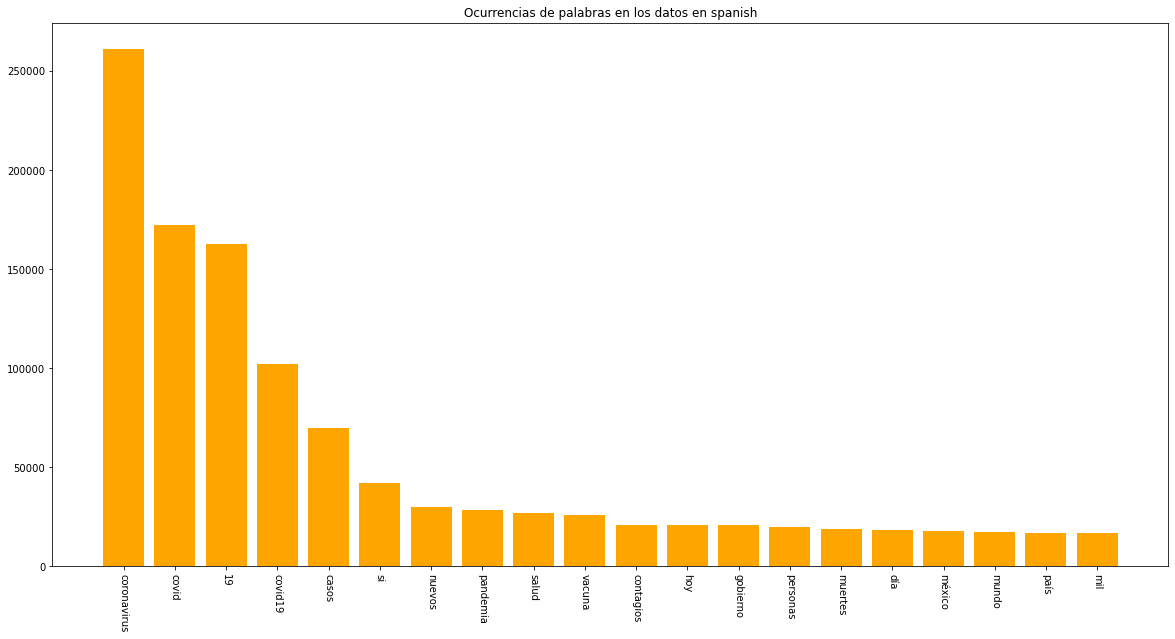

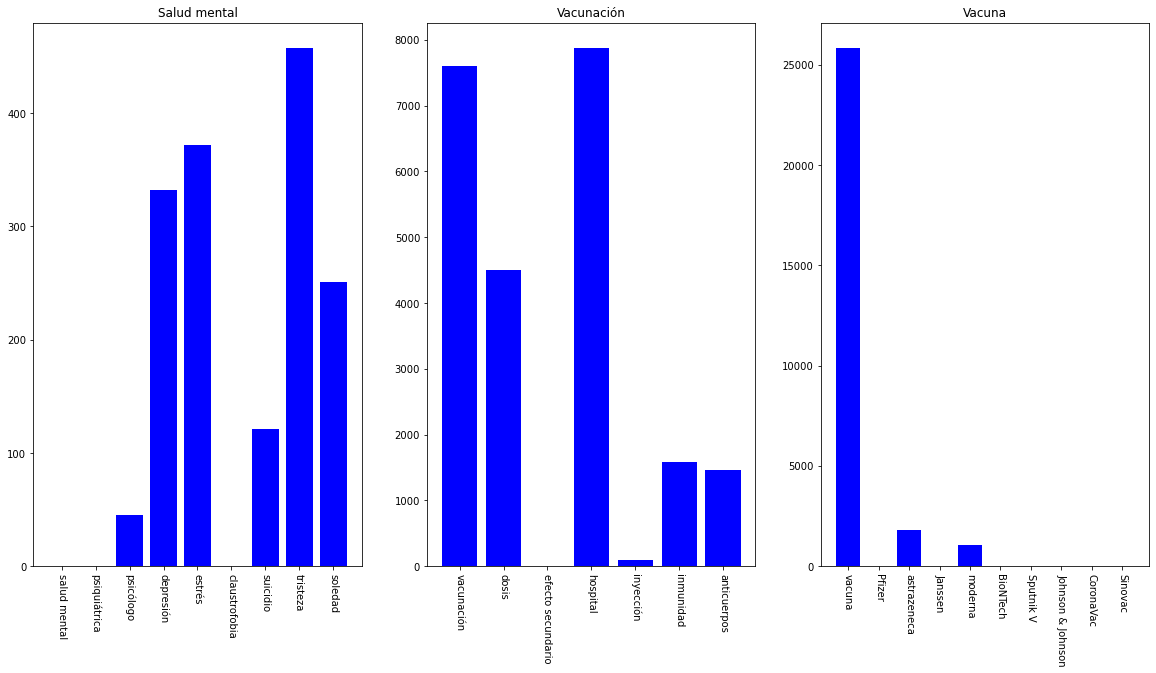

In [59]:
frecuenciasPorLenguaje(raw_spanish, 'spanish', vaccine_es, vaccination_es, mentalHealth_es)

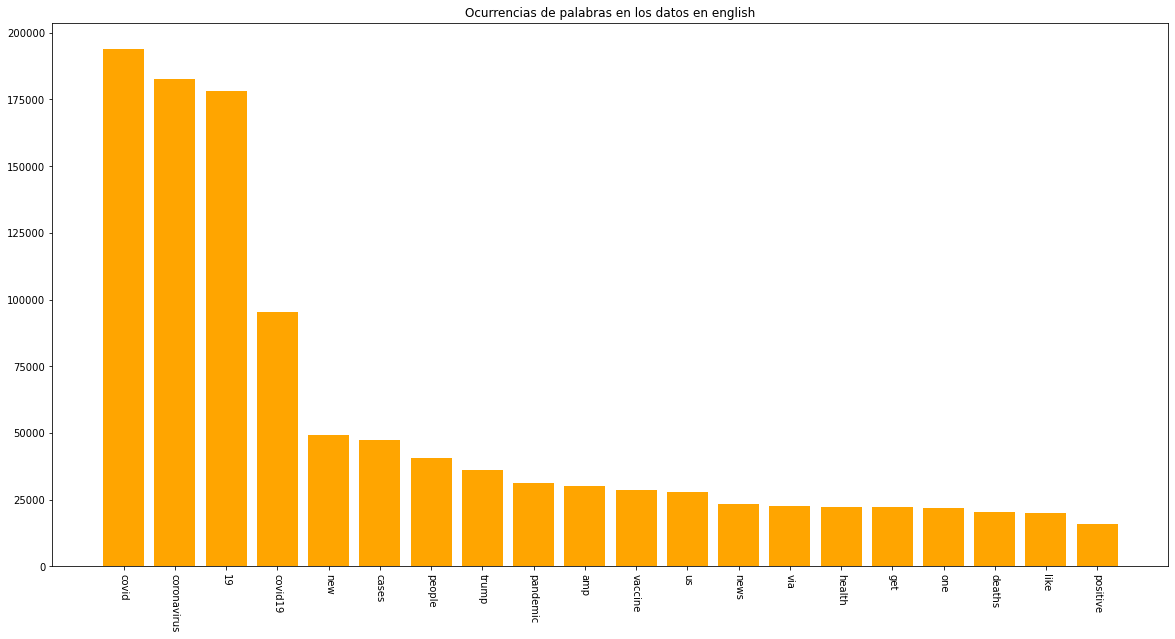

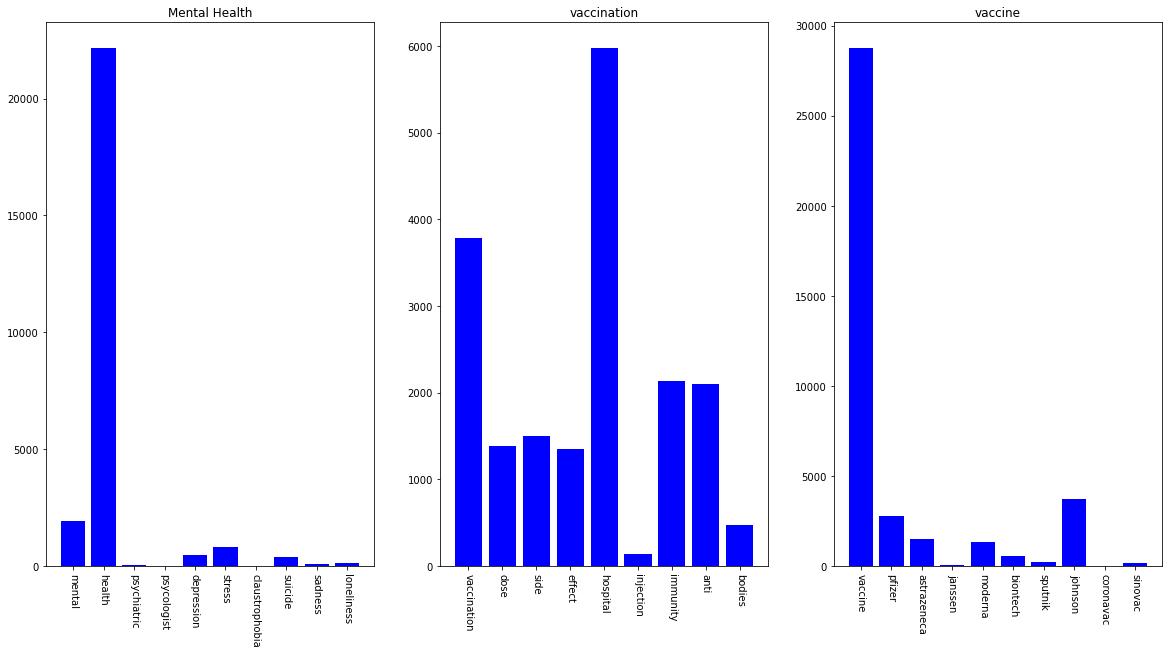

In [61]:
frecuenciasPorLenguaje(raw_english, 'english', vaccine_en, vaccination_en, mentalHealth_en)

Promedio de palabras por documento por idioma

In [35]:
def getAverageNrWordsPerDoc(dfLanguage):
    return dfLanguage['text'].str.split().str.len().mean()

In [36]:
avg_nro_words_spanish = getAverageNrWordsPerDoc(raw_spanish)
avg_nro_words_italian = getAverageNrWordsPerDoc(raw_italian)
avg_nro_words_english = getAverageNrWordsPerDoc(raw_english)

In [34]:

print('Promedio de palabras por documento en Español:', avg_nro_words_spanish)

print('Promedio de palabras por documento en Italiano:', avg_nro_words_italian)

print('Promedio de palabras por documento en Inglés:', avg_nro_words_italian)

14.521300252383085

Text(0.5, 0, 'Número de palabras')

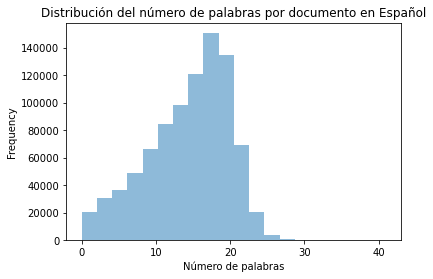

In [43]:
ax = raw_spanish['text'].str.split().str.len().plot.hist(bins=20, alpha=0.5)
ax.set_title('Distribución del número de palabras por documento en Español')
ax.set_xlabel('Número de palabras')

Text(0.5, 0, 'Número de palabras')

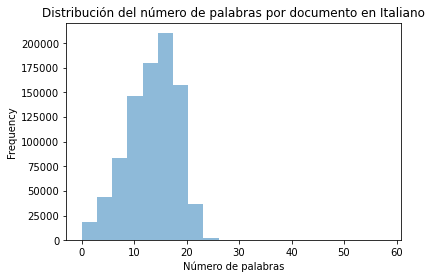

In [44]:
ax = raw_italian['text'].str.split().str.len().plot.hist(bins=20, alpha=0.5)
ax.set_title('Distribución del número de palabras por documento en Italiano')
ax.set_xlabel('Número de palabras')

Text(0.5, 0, 'Número de palabras')

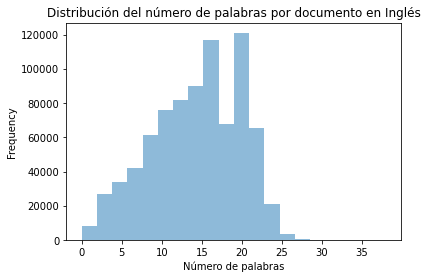

In [45]:
ax = raw_english['text'].str.split().str.len().plot.hist(bins=20, alpha=0.5)
ax.set_title('Distribución del número de palabras por documento en Inglés')
ax.set_xlabel('Número de palabras')

In [35]:
from datetime import datetime
# import datetimed
# datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
raw_italian['dates'] =  raw_italian['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
raw_spanish['dates'] =  raw_spanish['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
raw_english['dates'] =  raw_english['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))

Text(0, 0.5, 'Número de tweets')

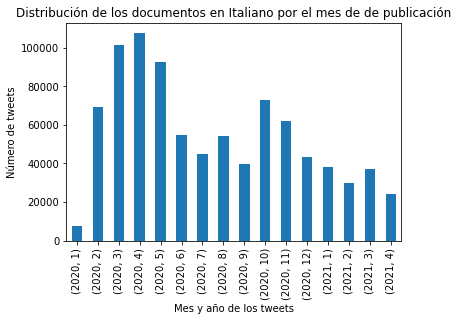

In [33]:
ax = raw_italian.groupby([raw_italian['dates'].dt.year, raw_italian['dates'].dt.month]).count()['id'].plot(kind="bar")
ax.set_title('Distribución de los documentos en Italiano por el mes de de publicación')
ax.set_xlabel('Mes y año de los tweets')
ax.set_ylabel('Número de tweets')


Text(0, 0.5, 'Número de tweets')

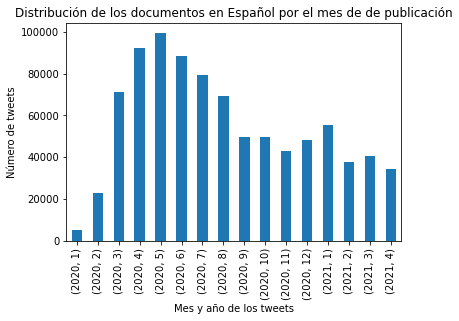

In [36]:
ax = raw_spanish.groupby([raw_spanish['dates'].dt.year, raw_spanish['dates'].dt.month]).count()['id'].plot(kind="bar")
ax.set_title('Distribución de los documentos en Español por el mes de de publicación')
ax.set_xlabel('Mes y año de los tweets')
ax.set_ylabel('Número de tweets')

Text(0, 0.5, 'Número de tweets')

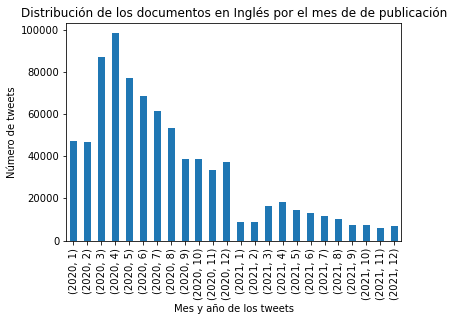

In [37]:
ax = raw_english.groupby([raw_english['dates'].dt.year, raw_spanish['dates'].dt.month]).count()['id'].plot(kind="bar")
ax.set_title('Distribución de los documentos en Inglés por el mes de de publicación')
ax.set_xlabel('Mes y año de los tweets')
ax.set_ylabel('Número de tweets')